# Coordinate Transform

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
R_LONG = 6378137
R_SHORT = 6356752.3142
E_EARTH: np.float64 = np.sqrt(1 - (R_SHORT / R_LONG) ** 2)

# MEAN_ALTITUDE = 12.711403


def lla_to_ecef(lon_rad, lat_rad, alt):
    N = R_LONG / np.sqrt(1 - E_EARTH ** 2 * np.sin(lat_rad))
    return (
        (N + alt) * np.cos(lat_rad) * np.cos(lon_rad),
        (N + alt) * np.cos(lat_rad) * np.sin(lon_rad),
        (N * (R_LONG / R_SHORT) ** 2 + alt) * np.sin(lat_rad),
    )

In [3]:
import os
from typing import cast

from matplotlib.artist import Artist
from matplotlib.axes import Axes

TRANS_MAP_DIR_SUFFIX = "agv_ns_ros/data/AGV_Map/"
TRANS_MAP_DIR = ""  # leave this empty to enable auto search

CWD = os.getcwd()

if not TRANS_MAP_DIR:
    current_dir = CWD
    while (parent_dir := os.path.dirname(current_dir)) != current_dir:
        current_dir = parent_dir
        map_dir_path = os.path.join(current_dir, TRANS_MAP_DIR_SUFFIX)
        if os.path.exists(map_dir_path):
            TRANS_MAP_DIR = map_dir_path
            break
    else:
        raise FileNotFoundError("Failed to find the transponder map file!")

trans_map_candidates = [
    file_name
    for file_name in os.listdir(TRANS_MAP_DIR)
    if file_name.startswith("TransMap") and file_name.endswith(".csv")
]
if len(trans_map_candidates) < 1:
    raise FileNotFoundError("Transponder map file not found!")
else:
    selected_trans_map_file_name = sorted(trans_map_candidates)[-1]

TRANS_MAP_PATH = os.path.join(TRANS_MAP_DIR, selected_trans_map_file_name)
print(f'Selected "{os.path.relpath(TRANS_MAP_PATH, CWD)}".')
df_trans_map = pd.read_csv(
    TRANS_MAP_PATH,
    names=["TransID", "AbsX", "AbsY", "LaneNB1", "LaneNB2"],
    index_col=0,
)
df_trans_map["x"] = df_trans_map["AbsX"] / 1000
df_trans_map["y"] = df_trans_map["AbsY"] / 1000


def plot_transponders(ax: Axes) -> None | Artist:
    handle = None
    for id in df_trans_map.index:
        handle = ax.plot(
            cast(np.float64, df_trans_map.loc[id, "x"]),
            cast(np.float64, df_trans_map.loc[id, "y"]),
            "+",
            ms=5,
            color="purple",
            alpha=0.5,
            **(dict(label="Transponders") if handle is None else {})  # type: ignore
        )[0]
    return handle

Selected "..\agv_ns_ros\data\AGV_Map\TransMap-20250107.csv".


## Data Loading

In [4]:
csv_paths = [
    "../local/log/2025/0106/01061441/tracking_control_node.csv",
    "../local/log/2025/0106/01061758/tracking_control_node.csv",
    "../local/log/2025/0107/01070930_蟹行生成失败/tracking_control_node.csv",
    "../local/log/2025/0107/01071357/tracking_control_node.csv",
    "../local/log/2025/0107/01071447_小蟹行失败/tracking_control_node.csv",
    "../local/log/2025/0107/01071532_斜行超出锁闭区/tracking_control_node.csv",
    "../local/log/2025/0107/01071600_蟹行回正晚/tracking_control_node.csv",
    "../local/log/2025/0107/01071804_小斜行1/tracking_control_node.csv",
    "../local/log/2025/0107/01071807_小斜行2/tracking_control_node.csv",
    "../local/log/2025/0108/01081504_交互区走两米就停/tracking_control_node.csv",
    "../local/log/2025/0108/01081513_重进交互区/tracking_control_node.csv",
    "../local/log/2025/0108/01081914/tracking_control_node.csv",
    "../local/log/2025/0108/01081937/tracking_control_node.csv",
    "../local/log/2025/0108/01082033/tracking_control_node.csv",
    "../local/log/2025/0108/01082105/tracking_control_node.csv",
    "../local/log/2025/0108/01082131/tracking_control_node.csv",
]

LOG_SAVE_PATH = "./coordinate_transform.csv.gz"

try:
    df_log = pd.concat([
        pd.read_csv(path, index_col=0) for path in csv_paths
    ])
except FileNotFoundError:
    print("Some source log file is unavailable. Saved CSV will be read instead.")
    df_log = pd.read_csv(LOG_SAVE_PATH, index_col=0)
else:
    df_log.to_csv(LOG_SAVE_PATH, compression="gzip")
    print("Read from source log file(s) and generated concatenated CSV file.")

Read from source log file(s) and generated concatenated CSV file.


In [5]:
lla_labels = ["gps_latitude", "gps_longitude", "gps_altitude"]
# lla_labels = [label[:7] + "_integrated" for label in lla_labels]

df_src = df_log.loc[
    (df_log["valid"] == 1)
    & (df_log[lla_labels[0]] != 0)
    & (df_log[lla_labels[1]] != 0)
    & (df_log[lla_labels[2]] != 0)
    # & np.isfinite(df_log["x_estimate"])
    # & np.isfinite(df_log["y_estimate"])
    & np.isfinite(df_log["x_original"])
    & np.isfinite(df_log["y_original"])
    & np.isfinite(df_log["x_real"])
    & np.isfinite(df_log["y_real"])
    # & ((df_log["x_original"] != df_log["x_estimate"])
    #     | (df_log["y_original"] != df_log["y_estimate"]))
    & np.isfinite(df_log[lla_labels[0]])
    & np.isfinite(df_log[lla_labels[1]])
    & np.isfinite(df_log[lla_labels[2]])
    # & ((df_log["x_original"] >= 560) | (df_log["y_original"] >= 90))
    # & (df_log["v_s"] <= 0.5)
]
if ("imu_ready_status" in df_src) and not df_src["imu_ready_status"].isna().any():
    print("Applied imu_ready_status filter.")
    df_src = df_src.loc[df_src["imu_ready_status"] == 1]
else:
    print("Skipped imu_ready_status filter.")
n_src = len(df_src)
print(f"{n_src} out of {len(df_log)} samples selected")

DELTA_HEADING = 0.12
lat = df_src[lla_labels[0]].to_numpy()
lon = df_src[lla_labels[1]].to_numpy()
alt = df_src[lla_labels[2]].to_numpy()
heading = df_src["heading"].to_numpy() + DELTA_HEADING
x_center = df_src["x_real"].to_numpy()
y_center = df_src["y_real"].to_numpy()

column_shape = (n_src, 1)
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

Applied imu_ready_status filter.
32064 out of 224053 samples selected


In [6]:
# i_0 = 0
i_0 = n_src // 2
# lat0_rad, lon0_rad, alt0 = \
#     lat_rad[i_0], lon_rad[i_0], alt[i_0]
lat0_rad, lon0_rad, alt0 = \
    lat_rad.mean(), lon_rad.mean(), alt.mean()
ecef_x0, ecef_y0, ecef_z0 = \
    lla_to_ecef(lon0_rad, lat0_rad, alt0)


def ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z):
    ecef_dx = ecef_x - ecef_x0
    ecef_dy = ecef_y - ecef_y0
    ecef_dz = ecef_z - ecef_z0
    e = -np.sin(lon_rad) * ecef_dx + np.cos(lon_rad) * ecef_dy
    n = -np.cos(lon_rad) * np.sin(lat_rad) * ecef_dx \
        - np.sin(lon_rad) * np.sin(lat_rad) * ecef_dy \
        + np.cos(lat_rad) * ecef_dz
    u = np.cos(lon_rad) * np.cos(lat_rad) * ecef_dx \
        + np.sin(lon_rad) * np.cos(lat_rad) * ecef_dy \
        + np.sin(lat_rad) * ecef_dz
    return e, n, u

### Original LLA

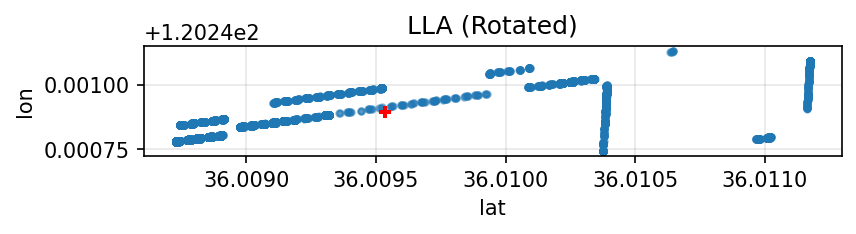

In [7]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ll = np.vstack([lat, lon])
ll_0 = np.array([ll[:, 0].tolist()] * ll.shape[1]).T
rotation = np.deg2rad(180 - 50)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ll_rotated = R @ (ll - ll_0) + ll_0
ax.plot(ll_rotated[0, :], ll_rotated[1, :], ".", alpha=0.5)

ll_origin = np.vstack([np.rad2deg(lat0_rad), np.rad2deg(lon0_rad)])
ll_origin_rotated = R @ (ll_origin - ll_0) + ll_0
ax.plot(ll_origin_rotated[0, :], ll_origin_rotated[1, :], "r+",
        label="LLA Origin")

ax.set(
    title="LLA (Rotated)",
    xlabel="lat",
    ylabel="lon",
    aspect="equal",
)
ax.grid(alpha=0.3)

### Original ECEF

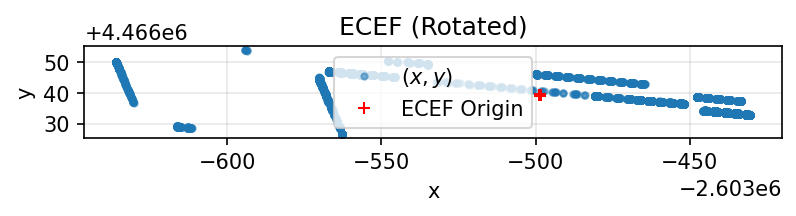

In [8]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ecef_x, ecef_y, ecef_z = \
    lla_to_ecef(lon_rad, lat_rad, alt)
ecef = np.vstack([ecef_x, ecef_y])
ecef_0 = np.array([ecef[:, 0].tolist()] * ecef.shape[1]).T
rotation = np.deg2rad(120)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ecef_rotated = R @ (ecef - ecef_0) + ecef_0
ax.plot(ecef_rotated[0, :], ecef_rotated[1, :], ".",
        alpha=0.5, label="$(x,y)$")

ecef_origin = np.vstack([ecef_x0, ecef_y0])
ecef_origin_rotated = R @ (ecef_origin - ecef_0) + ecef_0
ax.plot(ecef_origin_rotated[0, :], ecef_origin_rotated[1, :], "r+",
        label="ECEF Origin")

ax.set(
    title="ECEF (Rotated)",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

### Original ENU

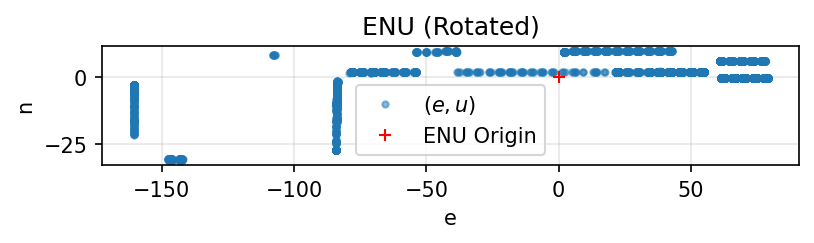

In [9]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

e, n, u = ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z)
en = np.vstack([e, n])
rotation = np.deg2rad(-38)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
en_rotated = R @ en
ax.plot(en_rotated[0, :], en_rotated[1, :], ".", alpha=0.5, label="$(e,u)$")

ax.plot(0, 0, "r+", label="ENU Origin")

ax.set(
    title="ENU (Rotated)",
    xlabel="e",
    ylabel="n",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

## Estimate Device Offset

Solution =
[[ 1.62041691e-01 -3.15587656e+00]
 [ 3.16930017e+00  1.10259548e-01]
 [ 7.90098901e-01 -6.13575919e-01]
 [ 6.06348761e-01  7.84288198e-01]
 [ 6.88675474e+02  1.25267685e+02]]
Residuals =
[34.91560082 23.46916174]
Rank =
5
Singular Values =
[12929.00699722   771.25637285   234.46579181    68.84682776
    50.85459307]
Condition Number =
254.23479407270364
Estimated Device Offset =
(0.136151, 3.162588)


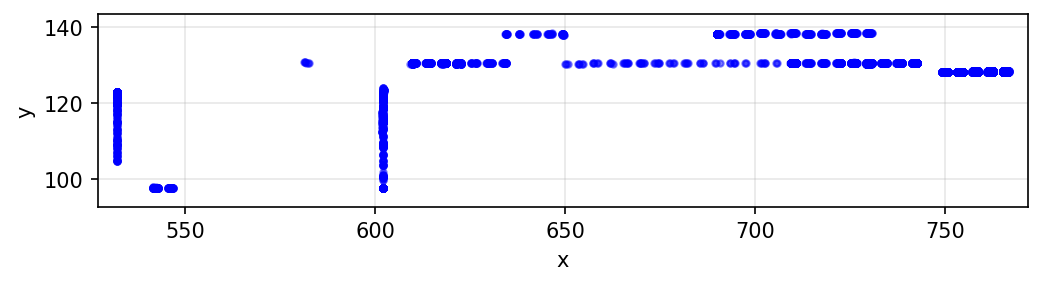

In [10]:
MODEL_DEGREE = 1

A_est = np.hstack([
    np.cos(heading).reshape(column_shape),
    np.sin(heading).reshape(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    # *([u.reshape(column_shape)] if MODEL_DEGREE >= 1 else []),
    *(
        [
            (e * n).reshape(column_shape),
            # (n * u).reshape(column_shape),
            # (u * e).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 1.5
        else []
    ),
    *(
        [
            (e ** 2).reshape(column_shape),
            (n ** 2).reshape(column_shape),
            # (u ** 2).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 2
        else []
    ),
    np.ones(column_shape),
])
b_est = np.hstack([
    x_center.reshape(column_shape),
    y_center.reshape(column_shape),
])

# estimation_slice = (x_center >= 620) & (x_center <= 720)
# A_est = np.compress(estimation_slice, A_est, axis=0)
# b_est = np.compress(estimation_slice, b_est, axis=0)

(
    solution_est,
    residuals_est,
    rank_est,
    singular_values_est
) = np.linalg.lstsq(A_est, b_est)
estimated_device_x = (np.abs(solution_est[0, 0]) + np.abs(solution_est[1, 1])) / 2
estimated_device_y = (np.abs(solution_est[1, 0]) + np.abs(solution_est[0, 1])) / 2
print("Solution =")
print(solution_est)
print("Residuals =")
print(residuals_est)
print("Rank =")
print(rank_est)
print("Singular Values =")
print(singular_values_est)
print("Condition Number =")
print(singular_values_est[0] / singular_values_est[-1])
print("Estimated Device Offset =")
print(f"({estimated_device_x:.6f}, {estimated_device_y:.6f})")

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(b_est[:, 0].ravel(), b_est[:, 1].ravel(), '.',
        color='blue', alpha=0.5, label='Samples For Estimating Device Offset')

ax.set(
    xlabel="x",
    xlim=(b_est[:, 0].min() - 5, b_est[:, 0].max() + 5),
    ylabel="y",
    ylim=(b_est[:, 1].min() - 5, b_est[:, 1].max() + 5),
    aspect='equal',
)
ax.grid(alpha=0.3)

## Fit Transform Formula

In [11]:
INS_OFFSET_X = 0.465
INS_OFFSET_Y = 2.950
INS_OFFSET_X = estimated_device_x
INS_OFFSET_Y = estimated_device_y
# INS_OFFSET_X = 0
# INS_OFFSET_Y = 0


def center_to_ins(center_x, center_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return center_x + offset_x, center_y + offset_y


def ins_to_center(ins_x, ins_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return ins_x - offset_x, ins_y - offset_y

### INS Ground Truth

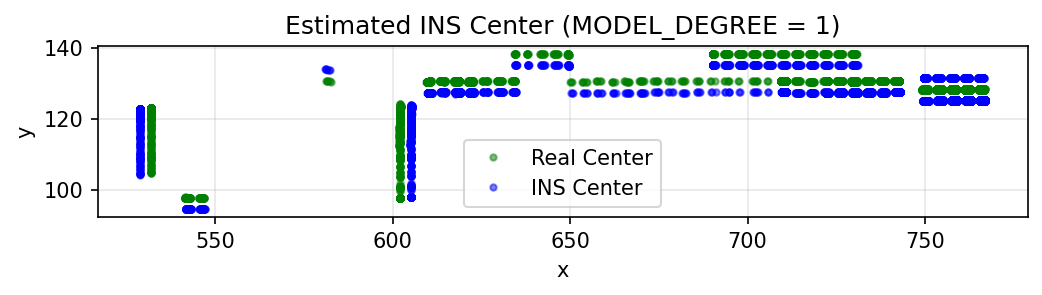

In [12]:
x_ins, y_ins = center_to_ins(x_center, y_center, heading)

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.", alpha=0.5, label="Real Center")
ax.plot(x_ins, y_ins, "b.", alpha=0.5, label="INS Center")

# x_center_recovered, y_center_recovered = \
#     ins_to_center(x_ins, y_ins, heading)
# ax.plot(x_center_recovered, y_center_recovered, "y-",
#         alpha=0.5, label="Recovered Center")

ax.set(
    title=f"Estimated INS Center (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

### Fitted Result

Solution =
[[ 6.88444082e+02  1.25224306e+02]
 [ 7.95070966e-01 -6.19293344e-01]
 [ 5.99506301e-01  7.91460658e-01]]
Residuals =
[704.03335618 193.33578656]
Rank =
3
Singular Values =
[12928.98984599   770.35846984   179.06423418]
Condition Number =
72.20308346249573


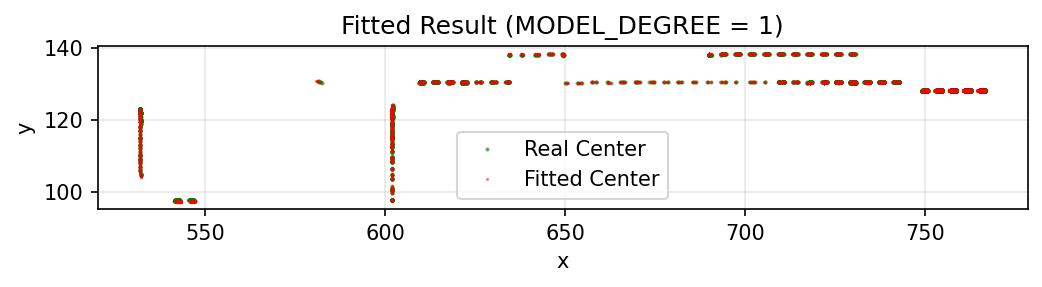

In [13]:
A_fit = np.hstack([
    np.ones(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    # *([u.reshape(column_shape)] if MODEL_DEGREE >= 1 else []),
    *(
        [
            (e * n).reshape(column_shape),
            # (n * u).reshape(column_shape),
            # (u * e).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 1.5
        else []
    ),
    *(
        [
            (e ** 2).reshape(column_shape),
            (n ** 2).reshape(column_shape),
            # (u ** 2).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 2
        else []
    ),
])
b_fit = np.hstack([
    x_ins.reshape(column_shape),
    y_ins.reshape(column_shape),
])
(
    solution_fit,
    residuals_fit,
    rank_fit,
    singular_values_fit
) = np.linalg.lstsq(A_fit, b_fit)
print("Solution =")
print(solution_fit)
print("Residuals =")
print(residuals_fit)
print("Rank =")
print(rank_fit)
print("Singular Values =")
print(singular_values_fit)
print("Condition Number =")
print(singular_values_fit[0] / singular_values_fit[-1])

ins_fitted = A_fit @ solution_fit
x_ins_fitted = ins_fitted[:, 0].ravel()
y_ins_fitted = ins_fitted[:, 1].ravel()
x_center_fitted, y_center_fitted = \
    ins_to_center(x_ins_fitted, y_ins_fitted, heading)

fig = plt.figure(figsize=(8, 8), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.", ms=2, alpha=0.5, label="Real Center")
ax.plot(x_center_fitted, y_center_fitted, "r.", ms=1,
        alpha=0.5, label="Fitted Center")

ax.set(
    title=f"Fitted Result (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

P(dis < 1) = 1.0
                dis
count  32064.000000
mean       0.111680
std        0.124559
min        0.000324
25%        0.047364
50%        0.076107
75%        0.101811
max        0.735553


,x_center,y_center,x_center_fitted,y_center_fitted,dis
8305,582.600220,130.406326,581.879003,130.550841,0.735553
29943,761.326782,128.263596,760.630122,128.228920,0.697522
29930,758.574585,128.231079,757.894768,128.216587,0.679972
29955,761.646973,128.263611,760.969558,128.231069,0.678196
29996,762.570679,128.260651,761.893146,128.230685,0.678195
29944,761.362305,128.262070,760.686139,128.227583,0.677045
29942,761.306274,128.263138,760.630122,128.228920,0.677017
29913,757.982483,128.232010,757.307279,128.208946,0.675598
29920,758.191284,128.232437,757.516999,128.214772,0.674517
29958,761.713135,128.261414,761.039464,128.233011,0.674269


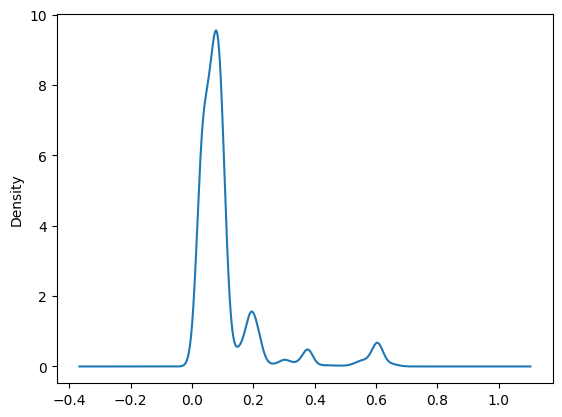

In [14]:
df_comp = pd.DataFrame({
    "x_center": x_center,
    "y_center": y_center,
    "x_center_fitted": x_center_fitted,
    "y_center_fitted": y_center_fitted,
})
dis = np.sqrt(
    (x_center_fitted - x_center) ** 2 + (y_center_fitted - y_center) ** 2
)
df_comp["dis"] = dis

threshold = 1
print(f"P(dis < {threshold}) =", (dis < threshold).sum() / len(dis))

print(df_comp[["dis"]].describe())

df_comp["dis"].plot.density()

df_comp.sort_values(by="dis", ascending=False, inplace=True)
df_comp.head(10)

### C++ Code

In [15]:
lat0 = np.rad2deg(lat0_rad)
lon0 = np.rad2deg(lon0_rad)

print("// 参考坐标")
print(f"const static double ORIGIN_LAT = {lat0:.12f}; // ENU 参考点纬度")
print(f"const static double ORIGIN_LON = {lon0:.12f}; // ENU 参考点经度")
print(f"const static double ORIGIN_ALT = {alt0:.12f}; // ENU 参考点海拔")
print(f"const static double INS_OFFSET_X = {INS_OFFSET_X:.12f}; // 定位点在车身坐标系下的 X 坐标")
print(f"const static double INS_OFFSET_Y = {INS_OFFSET_Y:.12f}; // 定位点在车身坐标系下的 Y 坐标")
print()
print("// 计算车辆中心坐标")
print(f"const double heading = AGVLocalization.Attitude.Heading + {DELTA_HEADING};")
print("const double cos_heading = cos(heading);")
print("const double sin_heading = sin(heading);")
print(
    (
        "center_x = %.12f"
        "\n    + INS_OFFSET_X * -cos_heading"
        "\n    + INS_OFFSET_Y * sin_heading"
        "\n    + %.12f * enu_x"
        "\n    + %.12f * enu_y"
        # + ("\n    + %.12f * enu_z" if MODEL_DEGREE >= 1 else "")
        + (
            "\n    + %.12f * (enu_x * enu_y)"
            # "\n    + %.12f * (enu_y * enu_z)"
            # "\n    + %.12f * (enu_z * enu_x)"
            if MODEL_DEGREE >= 1.5
            else ""
        )
        + (
            "\n    + %.12f * pow(enu_x, 2)"
            "\n    + %.12f * pow(enu_y, 2)"
            # "\n    + %.12f * pow(enu_z, 2)"
            if MODEL_DEGREE >= 2
            else ""
        )
        + ";"
    )
    % tuple(solution_fit[:, 0].ravel())
)
print(
    (
        "center_y = %.12f"
        "\n    + INS_OFFSET_X * -sin_heading"
        "\n    + INS_OFFSET_Y * -cos_heading"
        "\n    + %.12f * enu_x"
        "\n    + %.12f * enu_y"
        # + ("\n    + %.12f * enu_z" if MODEL_DEGREE >= 1 else "")
        + (
            "\n    + %.12f * (enu_x * enu_y)"
            # "\n    + %.12f * (enu_y * enu_z)"
            # "\n    + %.12f * (enu_z * enu_x)"
            if MODEL_DEGREE >= 1.5
            else ""
        )
        + (
            "\n    + %.12f * pow(enu_x, 2)"
            "\n    + %.12f * pow(enu_y, 2)"
            # "\n    + %.12f * pow(enu_z, 2)"
            if MODEL_DEGREE >= 2
            else ""
        )
        + ";"
    )
    % tuple(solution_fit[:, 1].ravel())
)

// 参考坐标
const static double ORIGIN_LAT = 36.010917738064; // ENU 参考点纬度
const static double ORIGIN_LON = 120.241580203343; // ENU 参考点经度
const static double ORIGIN_ALT = 10.114074663174; // ENU 参考点海拔
const static double INS_OFFSET_X = 0.136150619638; // 定位点在车身坐标系下的 X 坐标
const static double INS_OFFSET_Y = 3.162588364628; // 定位点在车身坐标系下的 Y 坐标

// 计算车辆中心坐标
const double heading = AGVLocalization.Attitude.Heading + 0.12;
const double cos_heading = cos(heading);
const double sin_heading = sin(heading);
center_x = 688.444081694646
    + INS_OFFSET_X * -cos_heading
    + INS_OFFSET_Y * sin_heading
    + 0.795070965749 * enu_x
    + 0.599506301098 * enu_y;
center_y = 125.224305951669
    + INS_OFFSET_X * -sin_heading
    + INS_OFFSET_Y * -cos_heading
    + -0.619293344176 * enu_x
    + 0.791460658070 * enu_y;


## Reproduction of Fusion Localization

### Module Translated

In [16]:
from typing import cast

CYCLIC_TIME = 1 / 20


class FusionLocalization:

    N_STATE: int
    N_OBSERVATIONS: int
    state: np.ndarray
    P: np.ndarray
    Q: np.ndarray
    Q0: np.ndarray
    R: np.ndarray
    last_time: np.int64
    time_intervals: list[np.float64]
    last_velocity_x: np.float64
    last_velocity_y: np.float64
    noise_factor: np.float64
    record: pd.Series
    init_finished: bool
    x_gnss: np.float64
    y_gnss: np.float64

    def __init__(self) -> None:
        N_STATE = 5
        N_OBSERVATIONS = 4
        self.N_STATE = N_STATE
        self.N_OBSERVATIONS = N_OBSERVATIONS
        self.state = np.zeros((N_STATE,))
        self.P = np.zeros((N_STATE, N_STATE))
        self.Q = np.zeros((N_STATE, N_STATE))
        self.R = np.zeros((N_OBSERVATIONS, N_OBSERVATIONS))
        self.error_history = []
        self.last_time = np.int64(0)
        self.time_intervals = []
        self.last_velocity_x = np.float64(0)
        self.last_velocity_y = np.float64(0)
        self.noise_factor = np.float64(1)
        self.init_finished = False
        self.x_gnss = self.y_gnss = np.float64(0)

    def lla_to_center(
        self,
        lat: np.float64,
        lon: np.float64,
        alt: np.float64,
    ) -> tuple[np.float64, np.float64]:
        lat_rad = np.deg2rad(lat)
        lon_rad = np.deg2rad(lon)
        ecef = lla_to_ecef(lon_rad, lat_rad, alt)
        e, n, u = ecef_to_enu(lon_rad, lat_rad, *ecef)
        A = np.array([
            [
                1,
                e, n,
                # *([u] if MODEL_DEGREE >= 1 else []),
                *(
                    [
                        e * n,
                        # n * u,
                        # u * e,
                    ]
                    if MODEL_DEGREE >= 1.5 else []
                ),
                *(
                    [
                        e ** 2,
                        n ** 2,
                        # u ** 2,
                    ]
                    if MODEL_DEGREE >= 2 else []
                ),
            ],
        ])
        ins = A @ solution_fit
        assert ins.shape == (1, 2), ins.shape
        heading = self.record["heading"] + DELTA_HEADING
        return ins_to_center(ins[0, 0], ins[0, 1], heading)

    def init_process_noise(self) -> None:
        self.Q0 = np.zeros_like(self.Q)
        self.Q0[0, 0] = 0.03  # x 方向位置噪声
        self.Q0[1, 1] = 0.03  # y 方向位置噪声
        self.Q0[2, 2] = 0.01  # 角速度噪声
        self.Q0[3, 3] = 0.1  # 线速度噪声
        self.Q0[4, 4] = 0.1  # 角度噪声
        self.Q = self.Q0

    def init_measurement_noise(self) -> None:
        self.R.fill(0)
        self.R[0, 0] = 0.02  # 磁钉位置 X 坐标的测量噪声
        self.R[1, 1] = 0.02  # 磁钉位置 Y 坐标的测量噪声
        self.R[2, 2] = 0.05  # GNSS 计算出车辆中心在堆场坐标系下 X 坐标的测量噪声
        self.R[3, 3] = 0.05  # GNSS 计算出车辆中心在堆场坐标系下 Y 坐标的测量噪声

    def check_ins_stability(self) -> bool:
        VELOCITY_CHANGE_THRESHOLD = 0.5

        vx = self.record["v_gx"]
        vy = self.record["v_gy"]

        delta_vx = abs(vx - self.last_velocity_x)
        delta_vy = abs(vy - self.last_velocity_y)

        self.last_velocity_x = vx
        self.last_velocity_y = vy

        return bool(
            (delta_vx < VELOCITY_CHANGE_THRESHOLD)
            and (delta_vy < VELOCITY_CHANGE_THRESHOLD)
        )

    def adjust_noise_covariances(self) -> None:
        if not self.check_ins_stability():
            self.noise_factor = np.min([
                self.noise_factor + 0.1,
                np.float64(2.0),
            ])
        else:
            self.noise_factor = np.max([
                self.noise_factor - 0.05,
                np.float64(1.0),
            ])

        self.Q = self.noise_factor * self.Q

    def predict(self, dt: np.float64) -> None:
        state = self.state
        record = self.record

        vx = record["v_gx"]
        vy = record["v_gy"]

        state[0] += vx * CYCLIC_TIME
        state[1] += vy * CYCLIC_TIME
        state[3] = vx
        state[4] = vy

        omega_z = record["omega_z"]
        state[2] += omega_z

        if state[2] > np.pi:
            state[2] -= np.pi
        elif state[2] < -np.pi:
            state[2] += np.pi

        F = np.eye(self.N_STATE)
        F[0, 3] = F[1, 4] = dt
        F[2, 2] = 1

        self.P = F @ self.P @ F.T + self.Q

    def update(self, x_gnss: np.float64, y_gnss: np.float64) -> None:
        record = self.record
        state = self.state

        H = np.zeros((self.N_OBSERVATIONS, self.N_STATE))
        H[2, 0] = H[3, 1] = 1
        H[0, 0] = H[1, 1] = 1

        z = np.array([
            record["x_original"],
            record["y_original"],
            x_gnss,
            y_gnss,
        ])

        if not (
            (z[0] >= 0)
            and (z[1] <= 850)
            and (z[2] >= 0)
            and (z[3] <= 850)
        ):
            return

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        y = z - H @ state

        self.state += K @ y

        I = np.eye(self.N_STATE)
        self.P = (I - K @ H) @ self.P

    def init(self) -> None:
        self.state.fill(0)
        self.P = np.eye(self.N_STATE)
        self.init_process_noise()
        self.init_measurement_noise()

    def cyclic(self, record: pd.Series) -> bool:

        self.record = record

        if not self.init_finished:
            if not (
                record["gps_longitude"] > 0
                and record["gps_latitude"] > 0
                and record["gps_altitude"] > 0
            ):
                # print("Waiting for valid gps data.")
                return False
            elif not (
                record["valid"] == 1
                and np.isfinite(record["x_real"])
                and np.isfinite(record["y_real"])
            ):
                # print("Waiting for transponder correction.")
                return False
            else:
                self.init_finished = True
                self.state[0] = record["x_center"]
                self.state[1] = record["y_center"]
                self.state[2] = record["heading"]

        current_time = np.int64(
            cast(pd.Timestamp, pd.to_datetime(record["timestamp"]))
            .to_pydatetime(warn=False)
            .timestamp() * 1000
        )
        if self.last_time == 0:
            self.last_time = current_time
            return False

        time_intervals = self.time_intervals
        dt = (current_time - self.last_time) / 1000
        if dt > 0:
            time_intervals.append(dt)
            if len(time_intervals) > 10:
                time_intervals.pop(0)

        averaged_dt = np.float64(1 / 20)
        if len(time_intervals) > 0:
            averaged_dt = np.mean(time_intervals)

        lat = record["gps_latitude"]
        lon = record["gps_longitude"]
        alt = record["gps_altitude"]
        x_gnss, y_gnss = self.lla_to_center(lat, lon, alt)
        self.x_gnss, self.y_gnss = x_gnss, y_gnss

        self.predict(averaged_dt)
        self.update(x_gnss, y_gnss)

        self.last_time = current_time

        self.adjust_noise_covariances()

        return True

### Iteration Replay

In [17]:
fusion_localization = FusionLocalization()
fusion_localization.init()

df_replay = pd.read_csv(
    "../local/log/2025/0108/01082131/tracking_control_node.csv",
    # "./coordinate_transform.csv.gz",
    index_col=0,
)
df_replay["x_state"] = df_replay["y_state"] = np.nan
df_replay["x_gnss"] = df_replay["y_gnss"] = np.nan
df_replay.fillna({"v_gx": 0, "v_gy": 0}, inplace=True)
df_replay["omega_z"] = df_replay["omega_z"].ffill()

init_count = 0
for i, (index, data) in enumerate(df_replay.iterrows()):
    last_state = fusion_localization.state.copy()

    cyclic_result = fusion_localization.cyclic(data)

    if not fusion_localization.init_finished:
        init_count += 1
        continue

    if not cyclic_result:
        continue

    if np.isnan(fusion_localization.state).any():
        print("input data =")
        print(data[["x_center", "y_center", "x_estimate", "y_estimate",
                    "heading", "v_gx", "v_gy", "omega_z"]])
        print("fusion_localization.state =", fusion_localization.state)
        raise RuntimeError("nan detected in state")

    df_replay.at[index, "x_gnss"] = fusion_localization.x_gnss
    df_replay.at[index, "y_gnss"] = fusion_localization.y_gnss
    df_replay.at[index, "x_replay"] = fusion_localization.state[0]
    df_replay.at[index, "y_replay"] = fusion_localization.state[1]

n_total = len(df_replay)
print(f"init_count: {init_count} (total: {n_total})")

init_count: 59 (total: 9028)


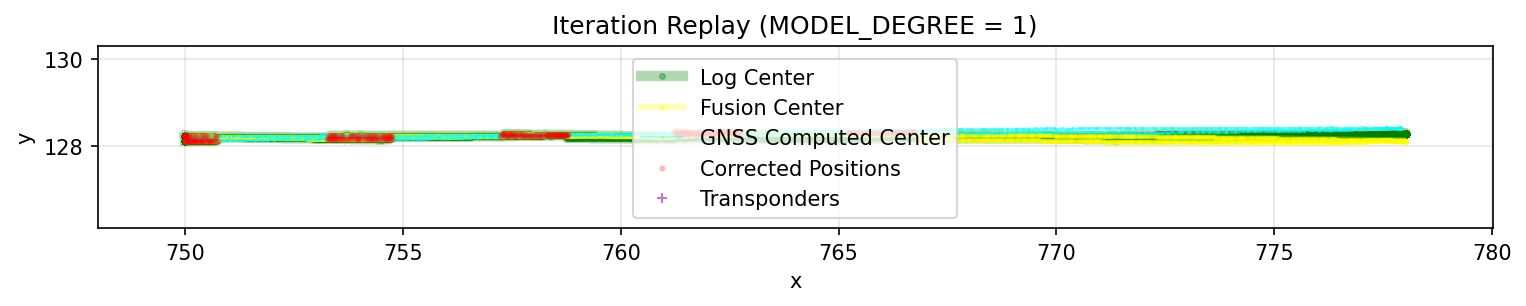

In [18]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

df_replay_masked = df_replay.loc[np.isfinite(df_replay["x_gnss"])]
ax.plot(df_replay_masked["x_center"], df_replay_masked["y_center"], ".-",
        ms=5, lw=5, color="green", alpha=0.3, label="Log Center")
ax.plot(df_replay_masked["x_replay"], df_replay_masked["y_replay"], ".-",
        ms=3, lw=3, color="yellow", alpha=0.3, label="Fusion Center")
ax.plot(df_replay_masked["x_gnss"], df_replay_masked["y_gnss"], ".-",
        ms=1, lw=1, color="cyan", alpha=0.3, label="GNSS Computed Center")

df_corrected = df_replay_masked.loc[
    (df_replay_masked["valid"] == 1)
    & np.isfinite(df_replay_masked["x_original"])
    & np.isfinite(df_replay_masked["y_original"])
    & np.isfinite(df_replay_masked["x_estimate"])
    & np.isfinite(df_replay_masked["y_estimate"])
    & np.isfinite(df_replay_masked["x_real"])
    & np.isfinite(df_replay_masked["y_real"])
].copy()
x_corrected = df_corrected["x_real"].to_numpy()
y_corrected = df_corrected["y_real"].to_numpy()
ax.plot(x_corrected, y_corrected, "o",
        ms=2, lw=0, color="red", alpha=0.2, label="Corrected Positions")
# ax.plot(df_replay_masked["x_gnss"], df_replay_masked["y_gnss"], "o",
#         ms=2, lw=0, color="orange", alpha=0.2, label="Corrected Fusion Positions")
# ax.plot(df_corrected["x_replay"], df_corrected["y_replay"], "o",
#         ms=1, lw=0, color="blue", alpha=0.2, label="Corrected GNSS Positions")

plot_transponders(ax)

ax.set(
    title=f"Iteration Replay (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    xlim=(
        df_replay_masked["x_center"].min() - 2,
        df_replay_masked["x_center"].max() + 2,
    ),
    ylabel="y",
    ylim=(
        df_replay_masked["y_center"].min() - 2,
        df_replay_masked["y_center"].max() + 2,
    ),
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

### Fusion Error

P(distance_fusion < 1.0) = 100.00%
P(distance_fusion < 0.9) = 100.00%
P(distance_fusion < 0.8) = 100.00%
P(distance_fusion < 0.7) = 100.00%
P(distance_fusion < 0.6) = 100.00%
P(distance_fusion < 0.5) = 100.00%
P(distance_fusion < 0.4) = 100.00%
P(distance_fusion < 0.3) = 100.00%
P(distance_fusion < 0.2) = 100.00%
P(distance_fusion < 0.1) = 100.00%


count    881.000000
mean       0.022612
std        0.010904
min        0.000098
25%        0.017588
50%        0.020764
75%        0.024258
max        0.069678
Name: distance_fusion, dtype: float64

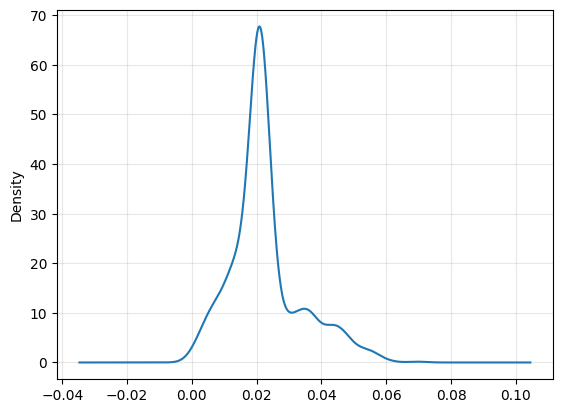

In [19]:
df_corrected["distance_fusion"] = np.sqrt(
    (df_corrected["x_replay"] - x_corrected) ** 2
    + (df_corrected["y_replay"] - y_corrected) ** 2
)

df_corrected["distance_fusion"].plot(kind="density")
plt.gca().grid(alpha=0.3)

for k in np.arange(1, 0, -0.1):
    p = (df_corrected["distance_fusion"] < k).mean()
    print(f"P(distance_fusion < {k:3.1f}) = {p:6.2%}")

df_corrected["distance_fusion"].describe()

In [20]:
pd.Series(df_corrected["x_replay"] - x_corrected).describe()

count    881.000000
mean       0.014999
std        0.011111
min       -0.030472
25%        0.009246
50%        0.019579
75%        0.021299
max        0.050391
Name: x_replay, dtype: float64

In [21]:
pd.Series(df_corrected["y_replay"] - y_corrected).describe()

count    881.000000
mean      -0.007651
std        0.014950
min       -0.060465
25%       -0.004840
50%       -0.001847
75%        0.000198
max        0.026628
Name: y_replay, dtype: float64

### GNSS Error

P(distance_gnss < 1.0) = 100.00%
P(distance_gnss < 0.9) = 100.00%
P(distance_gnss < 0.8) = 100.00%
P(distance_gnss < 0.7) = 100.00%
P(distance_gnss < 0.6) = 100.00%
P(distance_gnss < 0.5) = 100.00%
P(distance_gnss < 0.4) = 100.00%
P(distance_gnss < 0.3) = 100.00%
P(distance_gnss < 0.2) = 100.00%
P(distance_gnss < 0.1) = 94.44%

count    881.000000
mean       0.056810
std        0.025894
min        0.002919
25%        0.037304
50%        0.063514
75%        0.069585
max        0.159789
Name: distance_gnss, dtype: float64


,x_gnss,x_real,y_gnss,y_real,distance_gnss
7871,754.115944,753.956848,128.170326,128.155457,0.159789
7883,753.899051,753.746338,128.170088,128.158203,0.153175
7891,753.765954,753.615540,128.175071,128.158600,0.151313
7879,753.968957,753.818604,128.172030,128.155182,0.151294
7856,754.396027,754.247437,128.163640,128.150421,0.149176
...,...,...,...,...,...
2535,757.513581,757.511597,128.258927,128.263718,0.005186
2258,753.473530,753.471313,128.235041,128.230988,0.004619
2860,762.291065,762.291321,128.308784,128.313095,0.004319
2832,761.934359,761.930786,128.304662,128.303772,0.003682


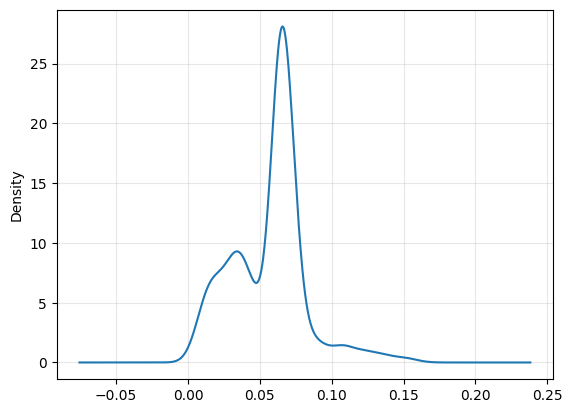

In [22]:
df_corrected["distance_gnss"] = np.sqrt(
    (df_corrected["x_gnss"] - x_corrected) ** 2
    + (df_corrected["y_gnss"] - y_corrected) ** 2
)

df_corrected["distance_gnss"].plot(kind="density")
plt.gca().grid(alpha=0.3)

for k in np.arange(1, 0, -0.1):
    p = (df_corrected["distance_gnss"] < k).mean()
    print(f"P(distance_gnss < {k:3.1f}) = {p:6.2%}")

print()
print(df_corrected["distance_gnss"].describe())

df_corrected.sort_values(by="distance_gnss", ascending=False) \
    [["x_gnss", "x_real", "y_gnss", "y_real", "distance_gnss"]]

In [23]:
pd.Series(df_corrected["x_gnss"] - x_corrected).describe()

count    881.000000
mean       0.050763
std        0.035038
min       -0.091222
25%        0.032942
50%        0.062844
75%        0.069560
max        0.159096
Name: x_gnss, dtype: float64

In [24]:
pd.Series(df_corrected["y_gnss"] - y_corrected).describe()

count    881.000000
mean      -0.003926
std        0.008868
min       -0.026698
25%       -0.009164
50%       -0.006527
75%        0.001364
max        0.022676
Name: y_gnss, dtype: float64